# Final Project: Estimating the Hurst Parameter with Visibility Graphs to measure Long Memory in Time Series

**Author**: Joseph Dasenbrock

**Abstract**

Time series analysis is dominated by the class of ARMA models, which model future values of the series as function of recent past values of the series. While these models have been successful in application, ARMA models have limitations founded in the assumptions being made about the nature of the underlying process. Time series analysis based on graphs (i.e. networks) offer potential for modeling which makes less strict assumptions, and opens up time series analysis to the rich mathematical toolset available to networks. The visibility graph is introduced and explored as one way to model a time series as a network. To exemplify the utility of such a model, the visibility graph is applied to the analysis of long memory in time series. A time series which possesses long memory is one which is significantly dependent on the entiriety of the history of the series, not just the most recent values. Long memory is introduced and visibility graphs are utilized to estimate the Hurst parameter and differentiate between simulated time series which exhibit long memory and series that do not exhibit such as property.

# Introduction



Among the most common tools for time series analysis is the AutoRegressive Moving Average model (ARMA). This class of models treats a time series as random process where future values are dependent on some small number of recent values of the series itself plus some number of recent values of the "white noise" in the time series. There are many different forms and variants of such models, however below is one common form ([1]): 

$$
\def \a {\alpha}
r_t = \phi_0 + \sum_{i=1}^{p} \phi_i r_{t-i} + \a_{t} - \sum_{i=1}^{q}\theta_i \a_{t-i}
$$

...where $p$ and $q$ are nonnegative integers, $r_i$ is the time series, and $\{\alpha_i\}$ is a white noise series derived from the time series.

To explain the above equation in words, the current value $r_t$ of the series is a function of a set of weights $\phi$, the most recent values of the series itself $r$, another set of weights $\theta$, and the most recent values of the white noise series $\alpha$.

While the ARMA class of models have been successfully used across many domains, these models have important limitations.

One of the most notable such limitations is the requirement that the modeled time series is stationary, i.e. the mean value of the series is the same over time. Clearly, real-world processes often do not have such a characteristic; any sampling of real-world time series can verify this (e.g. weekly rainfall totals, financial time series or bird population levels by geography are all time series not likely to exhibit stationarity). 

Often, time series can be converted to a stationary series with relatively simple adjustments, such as modeling the difference between the series and a choice of a trend model, or by modeling the period-to-period change in the series instead of the series itself. However, these adjustments can become onerous in implementation and are sometimes insufficient. For example, the level of deviation from the trend or the period-to-period differences can also fail to be stationary. 

Fundamental to such problems and others not mentioned here is that the ARMA model makes an assumption about the underlying nature of the time series process, i.e. that the future values of the series are determined by the most recent $p$ values of the series and the most recent $q$ values of the white noise process that is derived from the series. 

The ARMA model makes a possibly incorrect assumption about the underlying process, and it also offers little utility beyond merely forecasting future values of the series. There does not exist a rich set of properties of a time series that can be estimated utilizing the ARMA model, ARMA merely models the relationship between recent values of the series and the next value.

Translation of a time series into a graph (network) would offer advantages over the ARMA model as described here - a network would likely capture more of the idiosyncratic features of the data itself, instead of attempting to force the data into a certain framework. Also, translation of the series to a graph would make available the rich mathematical toolset available to graphs, and therefore more useful information could be extracted from the data. 

# Visibility Graphs



One such method of translating a time series into a network is a "visibility graph", which will be explored in this notebook. Lacasa et al 2008 ([6], [link][1]) provides a useful introduction to the visibility graph. In this section, the example given in the Lacasa paper will be implemented in code and the results will be demonstrated. 

[1]:https://dx.doi.org/10.1073/pnas.0709247105

Borrowing from first page of the the Lacasa paper, a visibility graph is a graph created from a time series where two values of the time series are connected if there is "visibility" between them. Conceptually, this means that two points are connected if one can be seen from the other without obstruction from some middle value of the time series. 

Mathematically, two points of the time series $(t_a, y_a)$, $(t_b, y_b)$ are connected in the visibility graph if, for any other data point $(t_c, y_c)$, there is: 

$$
y_c < + \left( y_a - y_b \right)\frac{t_b-t_c}{t_b-t_a} \qquad\textbf{(1)}
$$

...which corresponds to equation $\textbf{(1)}$ in Lacasa 2008. 

Now, we will replicate the simple time series presented in the first page of Lacasa 2008, using a python module that has been written by the author.

We will use `numpy` and `matplotlib`:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

...and the time series from Lacasa 2008 is created below:

In [2]:
# create data from lacasa paper
y = [87,49,36,83,]*5
y = np.array([x/100 for x in y]) 
n = len(y)
x = np.array(range(n)) 

...along with a plot:

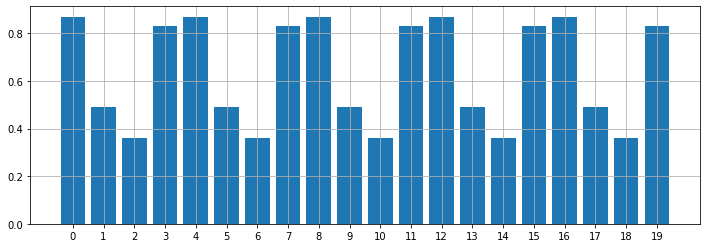

In [3]:
# import helper function used to create graph
from src import helpers 
fig = helpers.intro_plot(x, y)

Now, the custom module `build_visibility_graph` is loaded and aliased as `create_graph`. 

The function `create_edges` is used to create edges from `x` and `y`. This is accomplished by applying the inequality $\textbf{(1)}$ across every pair of points in the time series, i.e. the inequality is applied for every $(x_i, y_i)$, $(x_j, y_j)$ and for every $(x_c, y_c)$ between. If at any point the inequality fails to hold, no edge is created and the next pair is evaluated. 

The code can be viewed by [clicking on this link](src/build_visibility_graph.py), and the docstrings can be viewed by running the below cells:

In [4]:
from src import build_visibility_graph as create_graph 

In [5]:
# todo - uncomment these lines before submission
#?create_graph.create_edges

In [6]:
#?create_graph.points_connected

In [7]:
# inequality (1)
#?create_graph.connectedness_criteria_mid

Now we create the edges using the module and then graph the result:

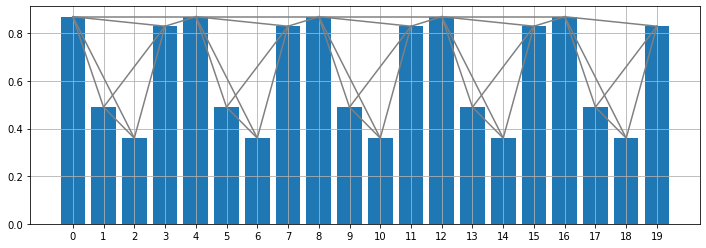

In [8]:
# create edges for network 
edges = create_graph.create_edges(x, y)

# plot the series with the edges
fig = helpers.intro_plot(x, y, edges=edges)

As discussed previously in this document, a potentially useful property of a visibility graph is that the resulting graph is invariant to scale, i.e. the time series scaled by a factor yields the same visibility graph.

This can be demonstrated by multiplying the $y$ value of the series and multiplying it by a factor, and then comparing the scaled version of the graph with the original. 

First, we record the original set of edges as `EDGES_BASE`:

In [9]:
# record the base edges 
EDGES_BASE = list(edges)

...and then compare `EDGES_BASE` with edges created from a scaled version of the graph:

In [10]:
def plot_adjusted(x, y, scale, plot=True, assertion=True):
    """Scales the input data by factor `scale`, compares to original
    
    Creates a barplot similar to previous plot, asserts that edges are 
    the same as EDGES_BASE (i.e. will raise error if not
    exactly the same).
    
    """
    global EDGES_BASE
    # multiply every value in y by the scalar
    y_adj = [i*scale for i in y]
    # create the visibility graph from the scaled edges
    edg = create_graph.create_edges(x, y_adj)
    
    # check that the outcome is the same as EDGES_BASE, if not raise an error
    f = lambda x: list(sorted(x))
    if assertion:
        msg = (f'Edge sets should be the same, scale={scale}. Expected '
               f'edges {EDGES_BASE}, calculated {edg}')
        assert f(edg) == f(EDGES_BASE), msg
    
    # plot the new graph
    if plot:
        fig = helpers.intro_plot(x, y_adj, edges=edg)

Using function `plot_adjusted`, we can scale the data by different scalars by passing different arguments. 

We scale by a factor of $2$ below:

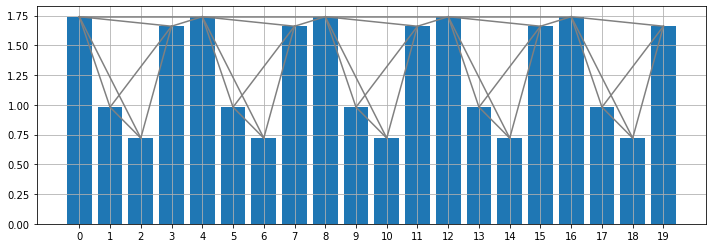

In [11]:
plot_adjusted(x, y, 2)

...and we can see that the $y$ values doubled, and the function completed without raising an `AssertionError`, therefore the visibility graphs are the same. 

We can also test a larger number of graphs (skipping the plot this time):

In [12]:
for sc in np.linspace(2, 1000, 25):
        plot_adjusted(x, y, sc, plot=False)

for sc in np.linspace(0.01, 1, 25):
        plot_adjusted(x, y, sc, plot=False)

Below is a simple widget that allows for inputting different scale values and immediately seeing the results.

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from warnings import warn

In [14]:
@interact
def adjusted_plot_interactive(scale='1e6'):
    global x
    global y
    if scale == '':
        return plot_adjusted(x, y, 1)
    else:
        try:
            scale = float(scale)
        except Exception as e:
            msg = (f'Error when trying to convert "scale" to float, '
                   f'is it numeric? Received "{scale}".') 
            warn(msg)
            raise Exception(msg)
        if not float(scale) > 0:
            msg = f'Scale must be greater than 0, received "{scale}".'
            warn(msg)
            raise Exception(msg)
            
        return plot_adjusted(x, y, float(scale))

interactive(children=(Text(value='1e6', description='scale'), Output()), _dom_classes=('widget-interact',))

# Fractional Brownian Motion and the Hurst Parameter

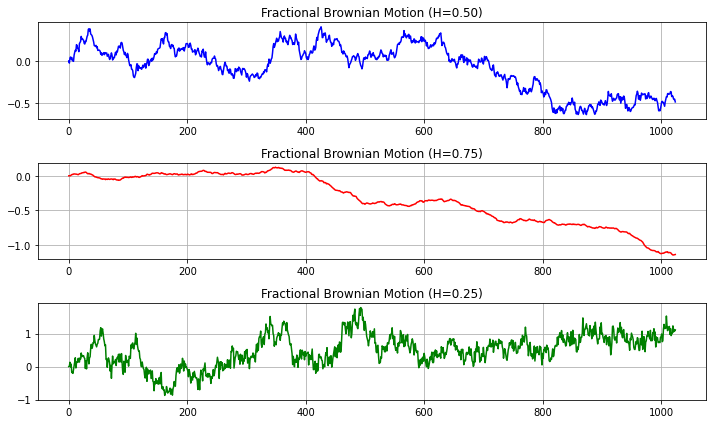

In [15]:
from matplotlib import pyplot as plt
# see source or https://pypi.org/project/fbm/
from src.fbm.fbm import FBM

f = lambda hurst: FBM(n=1024, hurst=hurst, length=1, method='daviesharte').fbm()

fig = plt.figure(figsize=(10,6))

def add(ax, hurst=0.5, color='blue'):
    y = f(hurst)
    ax.plot(range(len(y)), y, color=color)
    plt.grid()
    ax.set(title=f'Fractional Brownian Motion (H={hurst:.2f})')
    
ax1 = fig.add_subplot(311)
add(ax1, hurst=0.5)

ax2 = fig.add_subplot(312)
add(ax2, hurst=0.75, color='red')

ax3 = fig.add_subplot(313)
add(ax3, hurst=0.25, color='green')

plt.tight_layout()

# References

[1] Tsay, Ruey S. Analysis of Financial Time Series, Third Edition. 3rd ed. Wiley Series in Probability and Statistics. Hoboken, NJ: Wiley, 2010.

    
[2]: Graves, T., Gramacy, R., Watkins, N., Franzke, C. (2017). A Brief History of Long Memory: Hurst, Mandelbrot and the Road to ARFIMA, 1951–1980 Entropy https://dx.doi.org/10.3390/e19090437


[3]: Davies, R., Harte, D. (1987). Tests for Hurst Effect Biometrika  74(1), 95. https://dx.doi.org/10.2307/2336024


[4]: Lo, A. (1991). Long-Term Memory in Stock Market Prices Econometrica  59(5), 1279. https://dx.doi.org/10.2307/2938368


[5]: Lacasa, L., Luque, B., Luque, J., Nuño, J. (2009). The visibility graph: A new method for estimating the Hurst exponent of fractional Brownian motion EPL  86(3), 30001. https://dx.doi.org/10.1209/0295-5075/86/30001


[6]: Lacasa, L., Luque, B., Ballesteros, F., Luque, J., Nuño, J. (2008). From time series to complex networks: The visibility graph Proceedings of the National Academy of Sciences  105(13), 4972-4975. https://dx.doi.org/10.1073/pnas.0709247105


[7]: Lacasa, L., Nicosia, V., Latora, V. (2015). Network structure of multivariate time series Scientific Reports  5(1), 15508. https://dx.doi.org/10.1038/srep15508